In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import schedulefree

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

# Asymmetric and Non-Square Loss Function

We want a loss function with larger exponent than $2$, because we want to get closer to punishing the maximum error (which would be $n \to \infty$ for the exponent).

We might want an asymmetric loss function, as it is worse to predict a bias that is too small (because the relaxation would lose soundness in this case) than it is to predict a bias that is too large (here, we lose some precision, but are still sound).

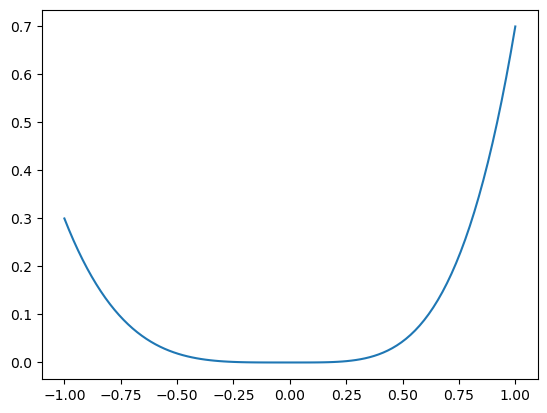

In [6]:
alpha = 0.7
beta = 4 
def foo(x): return torch.where(x >= 0, alpha*x**beta, (1 - alpha) * (-x)**beta)

x = torch.linspace(-1, 1, 100)
y = foo(x)
plt.plot(x, y)
plt.show()

Our loss function puts more emphasis on preventing unsoundness, when `alpha > 1/2` and more emphasis on precision, when `alpha < 1/2`.

The exponent can be changed by the `beta` argument.

In [7]:
def asymmetric_loss(y_hat, y, alpha=0.5, beta=4):
    return torch.where(y - y_hat >= 0, alpha * (y - y_hat)**beta, (1 - alpha) * (y_hat - y)**beta).mean()

# Training Loop

In [9]:
def train_loop(net, train_dataloader, val_dataloader, alpha=0.7, beta=4, patience=10, num_epochs=100, timeout=60, opt='adam', l1_weight=0):   
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters())
    elif opt == 'schedulefree':
        optimizer = schedulefree.AdamWScheduleFree(net.parameters(), lr=0.0025)
    else:
        raise ValueError('Uknown optimizer!')


    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    val_maxs = []
    best_val_loss = float('inf')
    early_stopping_cnt = 0
    t_start = time.time()
    for epoch in range(num_epochs):
        t_cur = time.time()
        if t_cur - t_start > timeout:
            print(f"Timeout reached ({t_cur - t_start} sec)")
            break 
        
        net.train()

        if opt == 'schedulefree':
            optimizer.train()

        train_loss = 0.
        train_mae = 0.
        for batch_X, batch_y in train_dataloader:
            y_hat = net(batch_X)
            loss = asymmetric_loss(y_hat, batch_y, alpha=alpha, beta=beta)

            l1_loss = 0
            for param in net.parameters():
                l1_loss += param.abs().sum()

            loss += l1_weight * l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(y_hat - batch_y).mean().item()

        train_loss /= len(train_dataloader)
        train_mae /= len(train_dataloader)
        train_losses.append(train_loss)
        train_maes.append(train_mae)


        net.eval()

        if opt == 'schedulefree':
            optimizer.eval()
            
        val_loss = 0
        val_mae = 0
        val_max = torch.tensor(0)
        with torch.no_grad():
            for batch_X, batch_y in val_dataloader:
                y_hat = net(batch_X)
                loss = asymmetric_loss(y_hat, batch_y, alpha=alpha, beta=beta)
                val_loss += loss.item()
                val_mae += torch.abs(y_hat - batch_y).mean().item()
                val_max = torch.maximum(val_max, torch.max(F.relu(batch_y - y_hat)))

        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        val_maxs.append(val_max.item())

        print(f"Epoch [{epoch + 1}/{num_epochs}] - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_mae: {train_mae:.4f}, val_mae: {val_mae:.4f}, val_max: {val_max.item():.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_cnt = 0
            best_net_state = net.state_dict()
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= patience:
                print(f"Stopping early (patience of {patience} reached)")
                break


    print("Training completed")
    return train_losses, val_losses, train_maes, val_maes, val_maxs, best_net_state

In [12]:
def make_nn(n_neurons, h, w):
    net = torch.nn.Sequential(torch.nn.Flatten(), 
                              torch.nn.Linear(3*h*w, n_neurons),     torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, 1))
    return net

# Training

In [10]:
ds_train = torch.load('./datasets/maxpool2x2_train_clean.pth')
ds_val   = torch.load('./datasets/maxpool2x2_val_clean.pth')

In [11]:
batch_size = 32
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(ds_val, batch_size=batch_size)

In [13]:
net = make_nn(50, 2, 2)
train_losses, val_losses, train_maes, val_maes, val_maxs, best_state = train_loop(net, train_dataloader, val_dataloader, timeout=300, 
                                                                                  alpha=0.7, beta=4,
                                                                                  patience=25, num_epochs=1000, l1_weight=1e-5)

Epoch [1/1000] - train_loss: 0.0006, val_loss: 0.0000, train_mae: 0.0579, val_mae: 0.0507, val_max: 0.2836
Epoch [2/1000] - train_loss: 0.0002, val_loss: 0.0000, train_mae: 0.0542, val_mae: 0.0557, val_max: 0.2841
Epoch [3/1000] - train_loss: 0.0002, val_loss: 0.0000, train_mae: 0.0535, val_mae: 0.0560, val_max: 0.2366
Timeout reached (366.23705434799194 sec)
Training completed


# Analyze Data

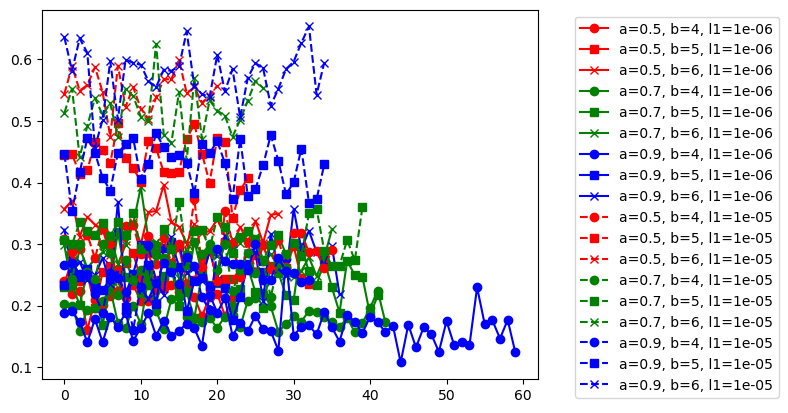

In [18]:
l1_weights = [1e-6, 1e-5]
alphas = [0.5, 0.7, 0.9]
betas = [4, 5, 6]

linestyles = {1e-6: '-', 1e-5: '--'}
colors = {0.5: 'r', 0.7: 'g', 0.9: 'b'}
markers = {4: 'o', 5: 's', 6: 'x'}

for l1_weight in l1_weights:
    for alpha in alphas:
        for beta in betas:
            netname = f"net6x50_{l1_weight}l1_{alpha}_{beta}"
            val_maxs = torch.load(f'./asym_loss_experiments/{netname}_val_maxs.pth')
            plt.plot(val_maxs, label=f"a={alpha}, b={beta}, l1={l1_weight}", color=colors[alpha], linestyle=linestyles[l1_weight], marker=markers[beta])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

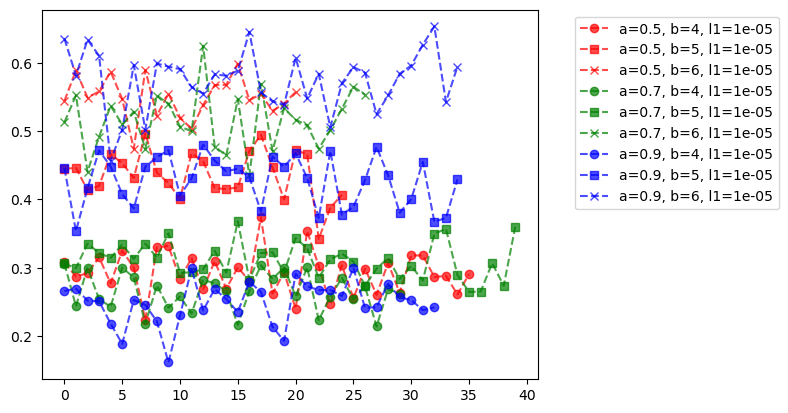

In [21]:
l1_weights = [1e-5]
alphas = [0.5, 0.7, 0.9]
betas = [4, 5, 6]

linestyles = {1e-6: '-', 1e-5: '--'}
colors = {0.5: 'r', 0.7: 'g', 0.9: 'b'}
markers = {4: 'o', 5: 's', 6: 'x'}

for l1_weight in l1_weights:
    for alpha in alphas:
        for beta in betas:
            netname = f"net6x50_{l1_weight}l1_{alpha}_{beta}"
            val_maxs = torch.load(f'./asym_loss_experiments/{netname}_val_maxs.pth')
            plt.plot(val_maxs, label=f"a={alpha}, b={beta}, l1={l1_weight}", color=colors[alpha], linestyle=linestyles[l1_weight], marker=markers[beta], alpha=0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

- A larger exponent is generally **worse** in terms of maximum error

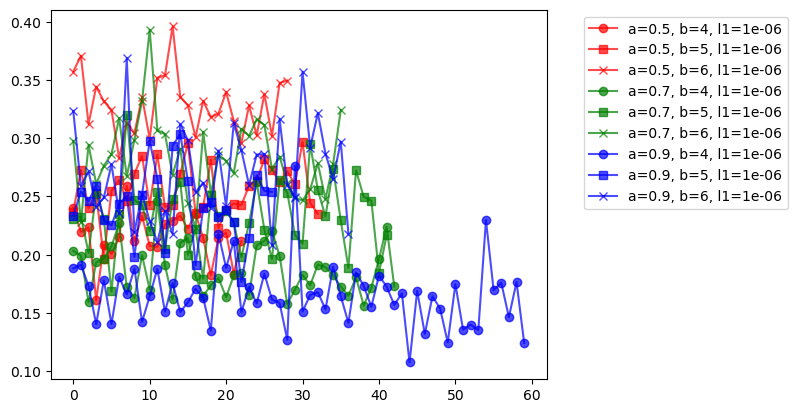

In [22]:
l1_weights = [1e-6]
alphas = [0.5, 0.7, 0.9]
betas = [4, 5, 6]

linestyles = {1e-6: '-', 1e-5: '--'}
colors = {0.5: 'r', 0.7: 'g', 0.9: 'b'}
markers = {4: 'o', 5: 's', 6: 'x'}

for l1_weight in l1_weights:
    for alpha in alphas:
        for beta in betas:
            netname = f"net6x50_{l1_weight}l1_{alpha}_{beta}"
            val_maxs = torch.load(f'./asym_loss_experiments/{netname}_val_maxs.pth')
            plt.plot(val_maxs, label=f"a={alpha}, b={beta}, l1={l1_weight}", color=colors[alpha], linestyle=linestyles[l1_weight], marker=markers[beta], alpha=0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

- The maximum error for networks trained with `1e-6` for $L_1$ regularization are  all generally better than for those with stronger regularization
- stronger $\alpha$ leads to better maximum error
- stronger exponent doesn't lead to better maximum error! (why not???)

In [23]:
ds_val = torch.load('./datasets/maxpool2x2_val_clean.pth')
X, y = ds_val[:]

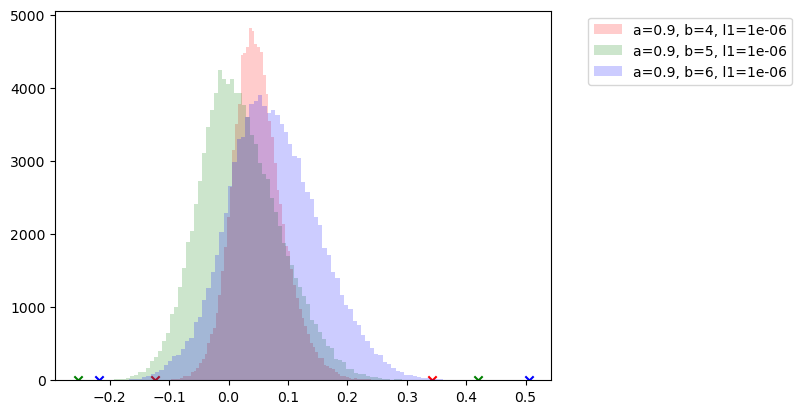

In [35]:
l1_weights = [1e-6]
alphas = [0.9]
betas = [4, 5, 6]

colors = {4: 'r', 5: 'g', 6: 'b'}

for l1_weight in l1_weights:
    for alpha in alphas:
        for beta in betas:
            netname = f"net6x50_{l1_weight}l1_{alpha}_{beta}"
            state = torch.load(f'./asym_loss_experiments/{netname}_best_state.pth')

            net = make_nn(50, 2, 2)
            net.load_state_dict(state)
            net.eval()
            y_hat = net(X)
            diff = y_hat - y
            plt.hist(diff.detach().numpy(), bins=100, label=f"a={alpha}, b={beta}, l1={l1_weight}", alpha=0.2, color=colors[beta])
            plt.scatter(diff.min().item(), 0, color=colors[beta], marker='x')
            plt.scatter(diff.max().item(), 0, color=colors[beta], marker='x')

plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

The larger exponent also has worse values for the actual minimum and maximum!